In [2]:
%load_ext autoreload
%autoreload 2

import bnl
import random

from bnl.metrics import bmeasure

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
## Now it's time to implement the B-measure
# let's start with the boundary hit rate for a proccessed Boundary Contour object
slm_ds = bnl.data.Dataset('~/data/salami/metadata.csv')

In [4]:
tid = random.choice(slm_ds.track_ids)
track = slm_ds[tid]

In [129]:
ref = list(track.refs.values())[0]
est = track.ests['mu1gamma9'].align(ref)
est_bc = est.contour('prob').clean('kde', bw=1).level('mean_shift', bw=0.15)
ref_bc = ref.contour('depth').level()

est_bc.plot().show()
ref_bc.plot().show()

## Let's look at how B-measure performs on SALAMI track that have two annotations

In [ ]:
slm_2anno_tracks = [t for t in slm_ds if len(t.refs) == 2]

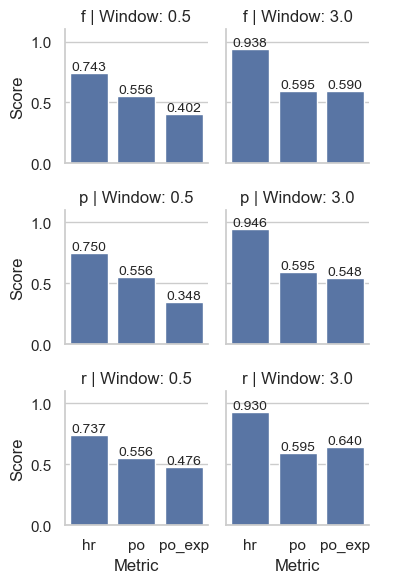

In [17]:
from bnl.exp import bmeasure_between_slm_refs
score_df = bmeasure_between_slm_refs(slm_ds[2])
bnl.viz.bmeasure_df(score_df)

In [ ]:
from pqdm.processes import pqdm
from bnl.exp import bmeasure_between_slm_refs
import bnl
import pandas as pd

slm_ds = bnl.data.Dataset(manifest_path="~/data/salami/metadata.csv")
list_of_dfs = pqdm(slm_ds, bmeasure_between_slm_refs, n_jobs=8)
valid_dfs = [x for x in list_of_dfs if type(x) is pd.DataFrame]
exp_results = pd.concat(valid_dfs, ignore_index=True)
exp_results.to_feather("bmeasure_slm_inter_anno_results.feather")

QUEUEING TASKS | :   0%|          | 0/1359 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1359 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1359 [00:00<?, ?it/s]

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
plotting_df = exp_results.pivot_table(
    index=["track_id", "prf"], columns=["metric", "window"], values="score"
).reset_index()

new_columns = ["_".join([str(f) for f in col if f]) for col in plotting_df.columns.values]
plotting_df.columns = new_columns
sns.set_theme(style="whitegrid")
for prf in ['f', 'p', 'r']:
    df = plotting_df[plotting_df['prf'] == prf]
    text = 'measure' if prf == 'f' else 'precision' if prf == 'p' else 'recall'
    plt.rcParams["figure.figsize"] = (4, 6.5) 
    sns.violinplot(data=df)
    plt.xticks(rotation=45)
    plt.title(f'Dist. of B-{text} with different windows', fontsize=14)
    plt.ylabel(f'B-{text}')
    plt.xlabel('Metric')
    plt.gca().set_ylim(-0.1, 1.1)
    plt.tight_layout()
    plt.savefig(f'B_violin_{prf}.pdf', bbox_inches='tight')
    plt.close()

In [51]:
plotting_df.columns.values

array(['track_id', 'prf', 'hr_0.5', 'hr_3.0', 'po_0.5', 'po_3.0',
       'po_exp_0.5', 'po_exp_3.0'], dtype=object)

In [ ]:
s = bnl.exp.mir_eval_between_slm_refs(slm_ds[2])


In [68]:
s2 = bnl.exp.mir_eval_between_slm_refs(slm_ds[3])

In [ ]:
collection = [s, s2, None]
valid_collection = [s for s in collection if type(s) is pd.Series]
pd.DataFrame(valid_collection).to_feather('mir_eval_inter_anno_results.feather')


,T-Precision reduced,T-Recall reduced,T-Measure reduced,T-Precision full,T-Recall full,T-Measure full,L-Precision,L-Recall,L-Measure,track_id
0,0.769864,0.724200,0.746334,0.859747,0.778611,0.817170,0.760085,0.712226,0.735378,2
1,0.830007,0.969007,0.894137,0.899566,0.976958,0.936666,0.555342,0.479529,0.514658,3


In [69]:
pd.DataFrame([s, s2])

,T-Precision reduced,T-Recall reduced,T-Measure reduced,T-Precision full,T-Recall full,T-Measure full,L-Precision,L-Recall,L-Measure,track_id
0,0.769864,0.724200,0.746334,0.859747,0.778611,0.817170,0.760085,0.712226,0.735378,2
1,0.830007,0.969007,0.894137,0.899566,0.976958,0.936666,0.555342,0.479529,0.514658,3


In [ ]:
bmeasure(ref_bc, est_bc, return_raw_data=True, reduced=False)

{'po_recall_num': 158.0,
 'po_recall_denom': 429.0,
 'po_precision_num': 158.0,
 'po_precision_denom': 359.0,
 'hr_num': 9.0,
 'hr_recall_denom': 46.0,
 'hr_precision_denom': 33.0,
 'ref_prominences': array([2., 2., 2., 2., 1., 1., 2., 1., 1., 2., 1., 1., 1., 1., 2., 1., 1.,
        2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1.,
        1., 2., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2.]),
 'est_prominences': array([3., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 2., 0., 2., 3., 3., 0.])}

In [3]:
from pqdm.processes import pqdm
from bnl.exp import bmeasure_mono_casting_effects as bmce
import bnl

slm_ds = bnl.data.Dataset(manifest_path="~/data/salami/metadata.csv")
list_of_dfs = pqdm(slm_ds, bmce, n_jobs=8)

QUEUEING TASKS | :   0%|          | 0/1359 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1359 [00:00<?, ?it/s]

Loading existing results for track 2 from ./monocasting_results_bmeasure/2.feather
Running experiment for track 6...
Running experiment for track 11...
Running experiment for track 3...
Running experiment for track 5...
Running experiment for track 4...
Running experiment for track 10...
Running experiment for track 7...
Running experiment for track 8...
Results for track 6 saved to ./monocasting_results_bmeasure/6.feather
Results for track 11 saved to ./monocasting_results_bmeasure/11.feather
Running experiment for track 12...
Running experiment for track 13...
Results for track 4 saved to ./monocasting_results_bmeasure/4.feather
Results for track 7 saved to ./monocasting_results_bmeasure/7.feather
Results for track 5 saved to ./monocasting_results_bmeasure/5.feather
Running experiment for track 14...
Running experiment for track 15...
Results for track 8 saved to ./monocasting_results_bmeasure/8.feather
Running experiment for track 16...
Results for track 3 saved to ./monocasting_res

COLLECTING RESULTS | :   0%|          | 0/1359 [00:00<?, ?it/s]

In [4]:
import pandas as pd
valid_dfs = [df for df in list_of_dfs if type(df) is pd.DataFrame]
len(valid_dfs)

1350

In [5]:
all_results_df = pd.concat(valid_dfs, ignore_index=True)
all_results_df

,tid,mono_casting,bdry_cleaning,leveling,window,reduced,bhr_num,bhr_rec_denom,bhr_prec_denom,bpo_rec_num,bpo_rec_denom,bpo_prec_num,bpo_prec_denom
0,2,depth,absorb,unique,0.5,False,11.0,59.0,21.0,3.0,10.0,3.0,47.0
1,2,depth,absorb,unique,0.5,True,11.0,59.0,21.0,3.0,10.0,3.0,10.0
2,2,depth,absorb,unique,3.0,False,20.0,59.0,21.0,51.0,96.0,51.0,162.0
3,2,depth,absorb,unique,3.0,True,20.0,59.0,21.0,51.0,96.0,21.0,54.0
4,2,depth,absorb,mean_shift,0.5,False,11.0,59.0,21.0,0.0,10.0,0.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64795,1655,prob,none,unique,3.0,True,12.0,18.0,33.0,27.0,32.0,0.0,4.0
64796,1655,prob,none,mean_shift,0.5,False,8.0,18.0,33.0,9.0,15.0,9.0,17.0
64797,1655,prob,none,mean_shift,0.5,True,8.0,18.0,33.0,9.0,15.0,3.0,5.0
64798,1655,prob,none,mean_shift,3.0,False,12.0,18.0,33.0,27.0,32.0,27.0,47.0


In [6]:
all_results_df.to_feather("monocasting_bmeasure.feather")

In [7]:
all_results_df.to_csv("monocasting_bmeasure.csv")